# IS4226 SYSTEMATIC TRADING: GROUP 10

**Contents:**
1. Preparation
2. Portfolio Selection
3. Common & Strategy Class
4. Training
5. Testing

**Strategy Description:**
Our selected strategy combines multiple indicators to create a robust trading approach involving both Mean Reversion and Momentum-based approach. Relative Strength Index (RSI) helps us assess the magnitude of recent price changes, while Bollinger Bands (BB) provides insights into price volatility and potential trend reversals. To further enhance our momentum trades, we added more signal confirmation by making use of Exponential Moving Average (EMA) to determine how far the current price is away from the EMA.


# Preparation

In [1]:
# Install all important libraries
!pip install yfinance
!pip install ta
!pip install matplotlib
# !pip install gurobipy

zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip


In [2]:
# Import all libraries

# import gurobipy as gp
from ta.volatility import BollingerBands
from ta.volatility import AverageTrueRange
from ta.trend import EMAIndicator
from ta.momentum import RSIIndicator
import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

# Portfolio Selection
Creating a diversified portfolio using Dow Jone Stocks. Generating the efficient frontier from Dow Jone stocks to minimise risk

In [ ]:
TRAIN_START = "2010-01-01"
TRAIN_END = "2016-12-31"

TEST_START = "2017-01-01"
TEST_END = "2019-12-31"

INITIAL_CAPITAL = 500000

INTERVAL = "1d"

symbols_list = [
"AXP",
"AMGN",
"AAPL",
"BA",
"CAT",
"CSCO",
"CVX",
"GS",
"HD",
"HON",
"IBM",
"INTC",
"JNJ",
"KO",
"JPM",
"MCD",
"MMM",
"MRK",
"MSFT",
"NKE",
"PG",
"TRV",
"UNH",
"CRM",
"VZ",
"V",
"WBA",
"WMT",
"DIS"
]
print(len(symbols_list))

data = yf.download(symbols_list, start=TRAIN_START, end=TRAIN_END, interval=INTERVAL)

#Matrix of Daily Closing Prices
closes = np.transpose(np.array(data.Close))
#Changes in Daily Closing Prices
absdiff = np.diff(closes)
#Relative Change in Daily Closing Prices
reldiff = np.divide(absdiff, closes[:,:-1])
#Mean Closing Price Change
delta = np.mean(reldiff, axis=1)
#Covariance
cov = np.cov(reldiff)
#Standard Deviation
std = np.std(reldiff, axis=1)

29
[*********************100%%**********************]  29 of 29 completed


In [ ]:
model = gp.Model('portfolio')
# Add matrix variable for the stocks
x = model.addMVar(len(symbols_list))
model.update()
# Minimize risk, measuring the historical correlation between Dow Jones stocks

portfolio_risk = x @ cov @ x

model.setObjective(portfolio_risk, gp.GRB.MINIMIZE)
model.update()
# Fix budget with a constraint
model.addConstr(x.sum() == 1, 'budget')
model.update()
# Verify model formulation
model.write('portfolio_selection_optimization.lp')
model.update()
# Optimize model to find the minimum risk portfolio
model.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 29 columns and 29 nonzeros
Model fingerprint: 0x0197caef
Model has 435 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-04, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 29 columns, 29 nonzeros
Presolved model has 435 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 28
 AA' NZ     : 4.060e+02
 Factor NZ  : 4.350e+02
 Factor Ops : 8.555e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.37760588e+05 -1.37760588e+05  2.90e+04 4.93e-06  1.00e+

In [ ]:
min_risk_volatility = math.sqrt(model.getAttr('ObjVal'))
min_risk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [min_risk_volatility, min_risk_return]),
             index=symbols_list + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
AXP,1.367544e-02
AMGN,5.688088e-08
AAPL,5.452509e-08
BA,2.356500e-08
CAT,1.742462e-08
CSCO,1.603184e-08
CVX,3.919123e-08
GS,3.042524e-08
HD,4.207287e-08
HON,5.053818e-08


In [ ]:
# Create an expression representing the expected return for the portfolio
portfolio_return = delta @ x
target = model.addConstr(portfolio_return == min_risk_return, 'target')
model.update()
# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target.rhs = r
    model.optimize()
    frontier = np.append(frontier, [[math.sqrt(model.ObjVal)],[r]], axis=1)


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 29 columns and 58 nonzeros
Model fingerprint: 0xdfa15674
Model has 435 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-04, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 29 columns, 58 nonzeros
Presolved model has 435 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 28
 AA' NZ     : 4.350e+02
 Factor NZ  : 4.650e+02
 Factor Ops : 9.455e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.37769002e+05 -1.37769002e+05  2.80e+04 1.10e-03  1.00e+

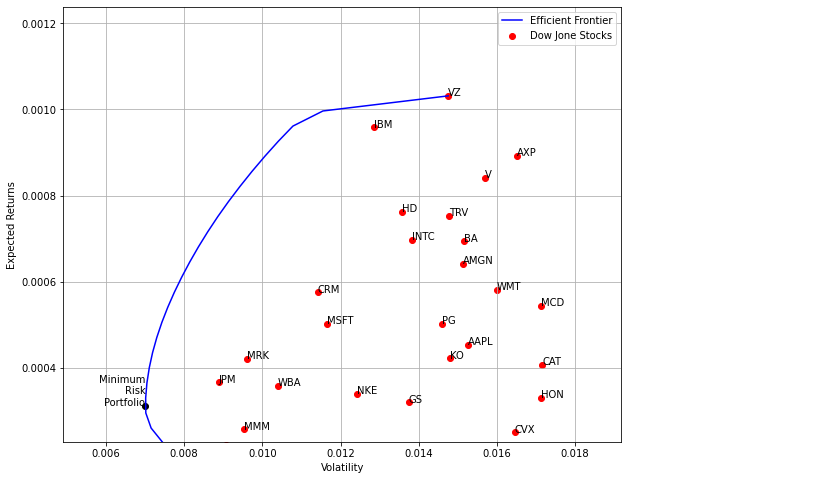

In [ ]:
#Plotting Efficient Frontier
fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std, y=delta,
           color='Red', label='Dow Jone Stocks')

for i, stock in enumerate(symbols_list):
    ax.annotate(stock, (std[i], delta[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=min_risk_volatility, y=min_risk_return, color='black')
ax.annotate('Minimum\nRisk\nPortfolio', (min_risk_volatility, min_risk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='Blue')

# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2, delta.max()*1.2])
ax.set_xlabel('Volatility')
ax.set_ylabel('Expected Returns')
ax.legend()
ax.grid()
plt.show()

From the efficient frontier, we select the stocks that are closest to the frontier. The stocks chosen differs in risk and returns, which diversifies our portfolio

["VZ", "IBM", "CRM", "MRK", "JPM"]

# Common Class

In [3]:
class Common_Class():
  def __init__(self, symbol, benchmark, start, end, interval, capital, transcation_cost, verbose = True):
    # fixed parameters for all runs
    self.all_data = {}
    self.benchmark_df = pd.DataFrame() # for DJI stock info
    self.symbol = symbol # list of stocks
    self.benchmark = benchmark # benchmark index
    self.start = start # start date
    self.end = end # end date
    self.trade_start = start # official strategy run start
    self.interval = interval # interval
    self.initial_capital = capital # this is the initial capital you want to trade with
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.verbose = verbose # if you want to see detailed output (logs)

    self.reset_run_data() # reset run data
    self.prepare_data() # prepares the data

  def prepare_data(self):
    # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
    # we will calculate the returns though.
    # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.

    for i in self.symbol:
      stock_data = yf.Ticker(i)
      hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
      bt_data = pd.DataFrame()
      bt_data["Close_Price"] = hist_stock["Close"]
      bt_data["High_Price"] = hist_stock["High"]
      bt_data["Low_Price"] = hist_stock["Low"]
      bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
      bt_data = bt_data.dropna()
      self.all_data['{}'.format(i)] = bt_data

    benchmark_data = yf.Ticker(self.benchmark)
    hist_benchmark = benchmark_data.history(start = self.start, end = self.end, interval = self.interval)
    self.benchmark_df["Close_Price"] = hist_benchmark["Close"]
    self.benchmark_df["Return"] = np.log(self.benchmark_df["Close_Price"] / self.benchmark_df["Close_Price"].shift(1))
    self.benchmark_df["Return_cum_sum"] = self.benchmark_df["Return"].cumsum()
    self.benchmark_df["Reg_Return"] = self.benchmark_df["Close_Price"].pct_change()
    self.benchmark_df = self.benchmark_df.dropna()

  def reset_run_data(self):
    self.position = {}
    self.quantity = {}
    for stock in self.symbol:
      self.quantity['{}'.format(stock)] = 0 #can also do at run strategy, but its different design
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade details
    self.performance_ratios = {} # portfolio's performance ratios
    self.transaction_cost_incurred = 0 # total transaction cost accumulated
    self.capital = self.initial_capital # this capital will change depending on trades
    self.trades = 0 # Number of trades

  def close_graph(self, stock):
    i = str(stock)
    plt.figure(figsize=(15, 5))
    plt.plot(self.all_data[i]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(i))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar, stock): #now we will also pass the stock as parameter
    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date
    i = str(stock)
    date = str(self.all_data[i].index[bar])[:10]  # :10 to only get the date
    price = self.all_data[i].Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):
    #returns the realised capital in your account at a given time period / bar
    date, price = self.return_date_price(bar, self.symbol[0]) # only concerned with date so any stock will do
    print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

  def unrealised_balance(self, bar):
    #returns you the unrealised capital (trades in progress) in your account at a given time period / bar
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub =  ub + self.quantity['{}'.format(stock)] *price
    #print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

  def total_balance(self, bar):
    #Unrealised plus realised
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub =  ub + self.quantity['{}'.format(stock)] *price
    tb = ub + self.capital
    #print("Date :{} | Total Balance: {:0.1f}".format(date,tb))
    return tb

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
    self.stored_data = pd.concat([self.stored_data, trade_detail])
    warnings.resetwarnings()

  def performance_plots(self):# once we have dataframe of daily account balances
    Final_result_data = self.Final_result_data #saving time to write self everywhere
    interval = str(self.interval)
    f,ax = plt.subplots(2,3,figsize=(20,10))

    #plot 1: Close Price of stock
    plt.subplot(2, 3, 1)
    for stock in self.symbol:
      plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
    plt.title("Cum Log returns of included stocks")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 2: Histogram of strategy returns
    plt.subplot(2, 3, 2)
    plt.hist(Final_result_data['capital_log_returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
    plt.title("Histogram of Strategy returns")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 3: Strategy vs Instrument
    plt.subplot(2, 3, 3)
    self.benchmark_df = self.benchmark_df.iloc[self.trade_start:].reset_index(drop=True)
    plt.plot(self.benchmark_df["Return_cum_sum"].dropna(), color='black', label ='Benchmark Returns', linestyle='dashed')
    plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'],color='red', label='Equal weighted stock Returns', linestyle='dashed')
    plt.plot(Final_result_data['capital_returns_log_cum_sum'].dropna(), label ='Strategy Returns')
    plt.title("Strategy Vs Stock Cum Return Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 4: Drawdown
    plt.subplot(2, 3, 4)
    plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
    plt.plot(Final_result_data["Cum_Max"].dropna(), label =  'Max Drawdown')
    plt.title("Drawdown")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 5: Equity Curve
    plt.subplot(2, 3, 5)
    plt.plot(Final_result_data["capital"].dropna(), label =  'Equity $')
    plt.title("Equity Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    plt.suptitle("Performance Plots")
    f.delaxes(ax[1,2]) # to delete the last subplot

    plt.show()

  def performance(self, p_verbose = True):
    # stored data has  [trade, date, position, price, symbol, quantity, capital]
    #B = self.stored_data # this will have many rows ; n(number of instruments) times more
    #C = self.all_data # will need this to aggregate the returns from all stocks
    #B.index = range(B.shape[0]/len(self.symbol))

    #Since the stocks are not stored in arranged manner, we need to arrange them so that we can get the entry price and exit price for each day
    #stored data has many rows, we will aggregate day wise

    df = pd.DataFrame() # creating a new datframe to store aggregated values

    df['capital'] = self.stored_data.groupby('date').agg({'capital': 'mean'})
    # agrregating by mean because the run is done in loop (for all stocks in a list of symbols),
    # so each stock "date" will have the same capital accounting for all stocks
    # you can print and see different metrics..

    # df.index = range(self.stored_data.shape[0]/len(self.symbol)) # shape[0] to get the length of rows of each stock and make an index for dataframe df

    trade_start_date = df['capital'].index[0] # If intraday, then index needs to be adjusted with time, for daily, its fine
    trade_end_date = df['capital'].index[-1] # This will work when interval is 1D

    #Also, since we have multiple stocks, we need to calculate expected returns to comapre against the strategy

    for stock in self.symbol:
      A = (self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist()) # The returns are already log
      df['Returns_{}'.format(stock)] = A
    c= df.columns #fetch all the columns of datframe
    df['Total_Stock_Returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol) # Sums up last N columns of df and divvide by number of stocks. Equal weightage
    df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
    df.index = range(df.shape[0])

    df['capital_after_settlement'] = df['capital'].shift(-1)

    # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
    #Remember, you can change the returns on investment based on the capital you trade

    df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital'] - 1)
    df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
    df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

    # for drawdown calculation
    df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
    df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]
    # The maximum difference is refered as "Drawdown"

    # COMMENTED OUT - DROP WILL REMOVE DAYS WITH 0 POSITION
    #df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True) #Dropping the last column, as I already got the values through shift(1)
    #df = df.dropna()
    #print(df.head())

    #storing the results in Final_result data
    Final_result_data = df

    #Plot the equity curve
    #plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])
    #Final_result_data[['exit_date', 'capital_after_settlement']].dropna().plot(figsize =(15,6), title = "Equity /Capital Plot")

    #Total Balance
    self.performance_ratios['end_capital'] = self.capital

    # Annual gross expected returns
    daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    self.performance_ratios['annual_regular_return'] = annual_regular_return

    # Annual std deviation
    daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5) *100
    self.performance_ratios['annual_regular_std'] = annual_regular_std

    #Annual Sharpe Ratio
    SR = annual_regular_return / annual_regular_std
    self.performance_ratios['sharpe_ratio'] = SR

    #The strategy returns on investment in percent

    #Total_Log_ret = Final_result_data['capital_log_returns'].sum()
    #Total_Log_ret
    #Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
    #print("The returns on investment from {} to {} by this strategy is {:0.2f} %".format(self.start, self.end, Regular_ROI))

    # the above method will also produce same result

    returns = (self.capital - self.initial_capital) /self.initial_capital *100
    self.performance_ratios['abs_returns'] = returns

    #Calculate Drawdown
    #Final_result_data[["capital_returns_log_cum_sum", "Cum_Max"]].dropna().plot(figsize =(15,6), title = "Drawdown Plot")
    max_drawdown = Final_result_data["drawdown"].max()*100
    self.performance_ratios['max_drawdown'] = max_drawdown

    # Calculate drawdown period
    zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]
    delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
    max_drawdown_period = delta_values.max()
    self.performance_ratios['max_drawdown_period'] = max_drawdown_period

    # Annual Calmar Ratio
    calmar_ratio = annual_regular_return / max_drawdown
    self.performance_ratios['calmar_ratio'] = calmar_ratio

    #Annual Sortino Ratio
    #Calculate the sortino ratio from the Final result data
    non_positive_returns = Final_result_data["capital_log_returns"].copy()
    non_positive_returns[non_positive_returns > 0] = 0
    neg_std_dev = (np.exp(non_positive_returns)-1).std() * (252**0.5) * 100
    sortino_ratio = annual_regular_return / neg_std_dev
    self.performance_ratios['sortino_ratio'] = sortino_ratio

    # Alpha and Beta against Benchmark
    bmk_reg_rets = self.benchmark_df[trade_start_date:trade_end_date].reset_index(drop=True)['Reg_Return']
    strat_reg_rets = Final_result_data['capital_regular_returns'].dropna()
    strat_cov = bmk_reg_rets.cov(strat_reg_rets)
    var = bmk_reg_rets.var()
    strat_beta = strat_cov / var
    benchmark_abs_regular_return = bmk_reg_rets.mean() * 252
    strat_abs_regular_return = strat_reg_rets.mean() * 252
    strat_alpha = (strat_abs_regular_return - strat_beta * benchmark_abs_regular_return)
    self.performance_ratios['strat_beta'] = strat_beta
    self.performance_ratios['strat_alpha'] = strat_alpha

    #Calculate any other ratio you want...

    #Total trades
    self.performance_ratios['total_trades'] = self.trades

    #Total transaction costs
    self.performance_ratios['transaction_costs'] = self.transaction_cost_incurred

    if p_verbose:
      print("="*50)
      print("Performance Metrics")
      print("The total capital at end of strategy: {:0.2f}".format(self.capital))
      print("The annual regular returns: {:0.2f} %".format(annual_regular_return))
      print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))
      print("The annual Sharpe Ratio: {:0.2f}".format(SR))
      print("The returns on investment from {} to {} by this strategy is {:0.2f} %".format(self.start, self.end, returns))
      print("The maximum drawdown: {:.2f} %".format(max_drawdown))
      print("The maximum drawdown period: {:.2f} days".format(max_drawdown_period))
      print("The annual Calmar Ratio: {:0.2f}".format(calmar_ratio))
      print("The annual Sortino Ratio: {:0.2f}".format(sortino_ratio))
      print("The strategy's beta is {:0.2f} and alpha is {:0.2f} against {}".format(strat_beta, strat_alpha, self.benchmark))
      print("The total trades taken by the strategy: {}".format(self.trades))
      print("The total transaction cost spent by the strategy: {:0.2f}".format(self.transaction_cost_incurred))
      print("="*50)

    self.Final_result_data = Final_result_data
    #print(self.Final_result_data.head())


  def buy_order(self,bar,stock,quantity=None,dollar=None):
    date, price = self.return_date_price(bar,stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.transaction_cost_incurred += (quantity * price) * self.transaction_cost
    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = 1
    tb = self.total_balance(bar)
    #self.quantity['{}'.format(stock)]*price + self.capital # this is just for one stock, however, I need for all the stocks
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
      self.realised_balance(bar)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)


  def sell_order(self,bar,stock,quantity=None,dollar=None):
    date, price = self.return_date_price(bar,stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.transaction_cost_incurred += (quantity * price) * self.transaction_cost
    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = -1
    tb = self.total_balance(bar) # to store the total balance due to all the stocks at the end of the day, so that I get 1 value at the EOD
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
      self.realised_balance(bar)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)


  def last_trade(self, bar): # this needs to be check for all open positions of all stocks

    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      last_quantity = self.quantity['{}'.format(stock)]
      self.capital = self.capital + last_quantity * price
      self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
      self.trades = self.trades +1
      if self.position['{}'.format(stock)] == -1: # if closing out a short position
        last_quantity = - last_quantity # to keep a positve nymber in records. Note, self.quantity is always maintianing a +/- sign.
        self.position['{}'.format(stock)] = 1 # to record we are buying to close out
      else:
        last_quantity = last_quantity # to keep a positve nymber in records
        self.position['{}'.format(stock)] = -1 # to record we are selling to close out
      #self.position = 0
      tb = self.total_balance(bar)
      self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

      if self.verbose:
        print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))


# Group 10 Strategy
Mean Reversion / Momentum Approach

1. Mean Reversion: RSI Oversold/Overbought + BB Upper/Lower bands
2. Momementum: RSI Upper/Lower threshold + EMA

Additionally, dynamic entry levels + trailing stop loss

Performance Metrics
The total capital at end of strategy: 1092664.85
The annual regular returns: 12.45 %
The annual regular std deviation: 13.56 %
The annual Sharpe Ratio: 0.92
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 118.53 %
The maximum drawdown: 15.26 %
The maximum drawdown period: 470.00 days
The annual Calmar Ratio: 0.82
The annual Sortino Ratio: 1.59
The strategy's beta is -0.05 and alpha is 0.13 against ^DJI
The total trades taken by the strategy: 248
The total transaction cost spent by the strategy: 179171.65


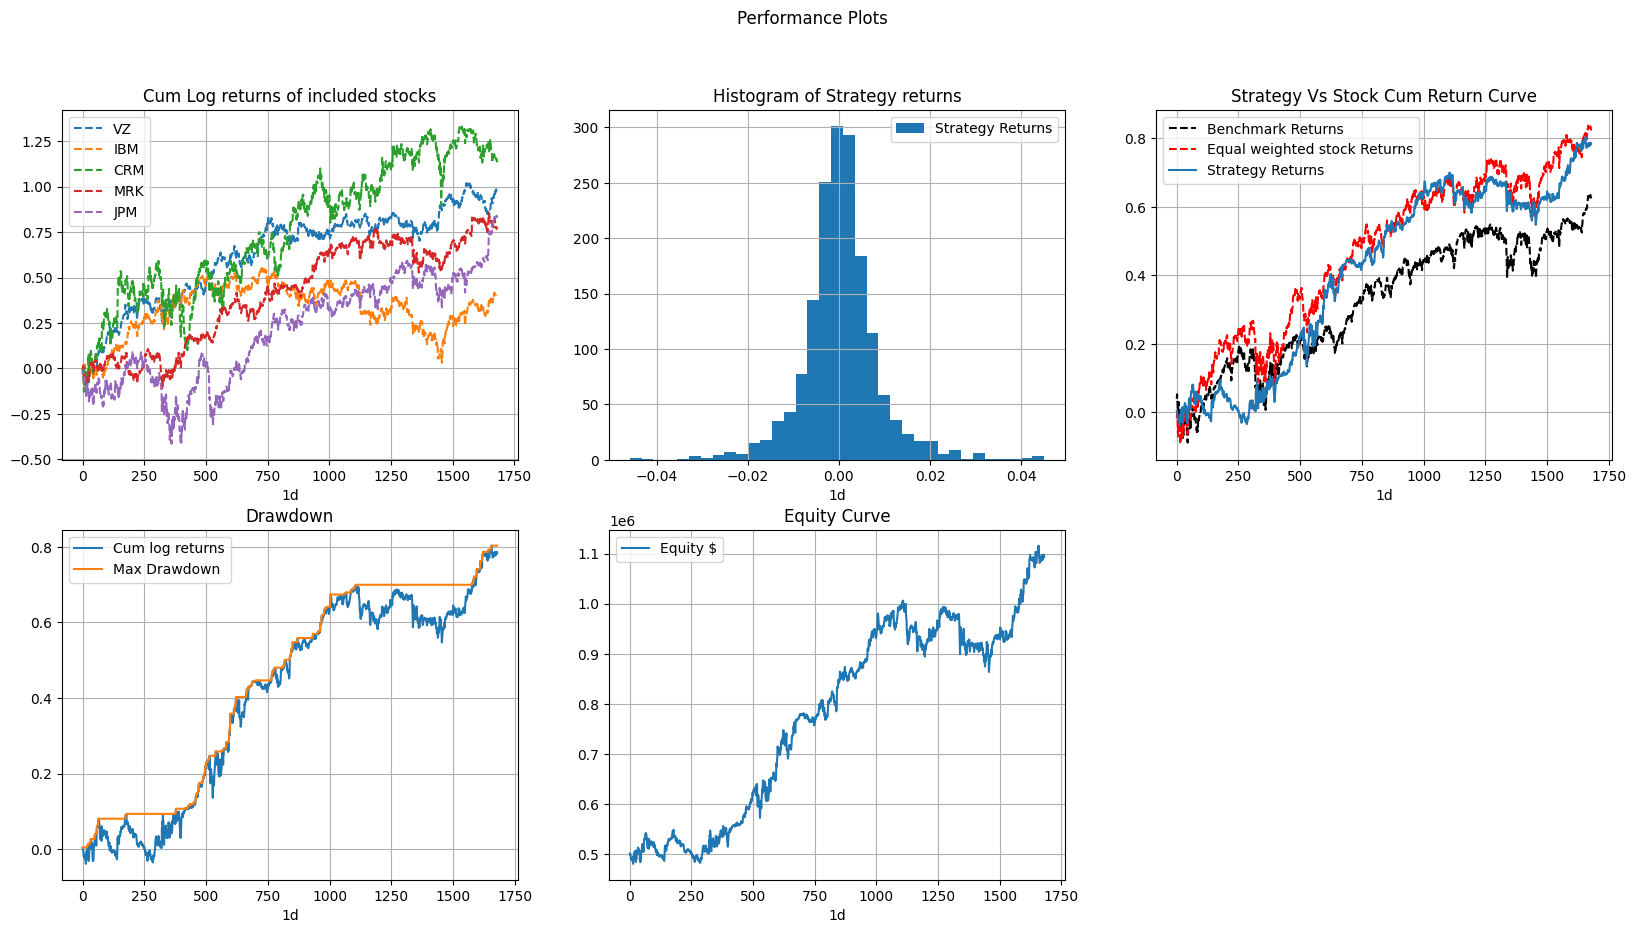

In [7]:
class G10_Strategy(Common_Class):

  # to update take profit and stop loss tracker
  def update_tp_sl(self, stock, price, atr, tp_multiplier, sl_multiplier):
    if self.position['{}'.format(stock)] == 1:
      tp, sl = price + atr * tp_multiplier, price - atr * sl_multiplier
    elif self.position['{}'.format(stock)] == -1:
      tp, sl = price - atr * tp_multiplier, price + atr * sl_multiplier
    self.tp_sl_price['{}'.format(stock)] = (tp, sl)
    self.prev_price['{}'.format(stock)] = price


  # SL will increase with price increase
  def trail_sl(self, stock, price):
    prev_price = self.prev_price['{}'.format(stock)]
    price_delta = price - prev_price
    tp, sl = self.tp_sl_price['{}'.format(stock)]
    if self.position['{}'.format(stock)] == 1 and price_delta > 0: # LONG and price above high
        self.tp_sl_price['{}'.format(stock)] = (tp, sl + price_delta) # increase SL
        self.prev_price['{}'.format(stock)] = max(prev_price, price) # update previous high
    elif self.position['{}'.format(stock)] == -1 and price_delta < 0: # SHORT and price below low
        self.tp_sl_price['{}'.format(stock)] = (tp, sl + price_delta) # decrease SL (delta is -ve!)
        self.prev_price['{}'.format(stock)] = min(prev_price, price) # update previous low


  # close existing position
  def close_existing(self, bar, stock):
    if self.position['{}'.format(stock)] == -1:
      self.buy_order(bar,stock,quantity = -self.quantity['{}'.format(stock)]) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
    elif self.position['{}'.format(stock)] == 1:
      self.sell_order(bar,stock,quantity = self.quantity['{}'.format(stock)]) #to clear previous long position
    self.position['{}'.format(stock)] = 0 # important to reset to 0 only after closing existing


  def go_long(self, bar, stock, quantity = None, dollar = None): # fresh position
    if quantity:
      self.buy_order(bar, stock, quantity = quantity)
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      self.buy_order(bar, stock, dollar = dollar)


  def go_short(self, bar, stock, quantity = None, dollar = None): # fresh position
    if quantity:
      self.sell_order(bar, stock, quantity = quantity)
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      self.sell_order(bar, stock, dollar = dollar)


  def update_indicators(self, stock, rsi_window, bb_window, bb_sd, ema_window, atr_window):
      indicator_rsi = RSIIndicator(close = self.all_data['{}'.format(stock)]["Close_Price"], window =rsi_window, fillna=False)
      indicator_bb = BollingerBands(close = self.all_data['{}'.format(stock)]["Close_Price"], window=bb_window, window_dev=bb_sd)
      indicator_ema = EMAIndicator(close = self.all_data['{}'.format(stock)]["Close_Price"], window=ema_window)
      indicator_atr = AverageTrueRange(high = self.all_data['{}'.format(stock)]["High_Price"], low = self.all_data['{}'.format(stock)]["Low_Price"], close = self.all_data['{}'.format(stock)]["Close_Price"], window = atr_window, fillna = False)

      rsi = indicator_rsi.rsi()
      upper_band = indicator_bb.bollinger_hband()
      mavg_band = indicator_bb.bollinger_mavg()
      lower_band = indicator_bb.bollinger_lband()
      ema = indicator_ema.ema_indicator()
      atr = indicator_atr.average_true_range()

      # hard update all indicators
      self.all_data['{}'.format(stock)]['ATR'] = atr
      self.all_data['{}'.format(stock)]['RSI'] = rsi
      self.all_data['{}'.format(stock)]['BB_UPPER_BAND'] = upper_band
      self.all_data['{}'.format(stock)]['BB_MAVG_BAND'] = mavg_band
      self.all_data['{}'.format(stock)]['BB_LOWER_BAND'] = lower_band
      self.all_data['{}'.format(stock)]['EMA'] = ema


  def run_strategy(self, rsi_window=14, bb_window=20, bb_sd=2, rsi_oversold=30, rsi_overbought=70, rsi_lower_threshold=45, rsi_upper_threshold=55, atr_window=14, atr_multiplier=4, ema_window=80, ema_range=0.040, entry_ratio=0.5): # add the parameters according to the strategy
    self.reset_run_data() # reset previous run data
    self.stop = False # I will use this to make sure NO trading when balance = 0 OR lost all money
    # track tp/sl, previous high/low set for current order
    self.tp_sl_price = {}
    self.prev_price = {}

    #Preparing data and initialising with 0 quantity, 0 position and 0 tpsl prices
    for stock in self.symbol:
      self.quantity['{}'.format(stock)] = 0
      self.position['{}'.format(stock)] = 0
      self.tp_sl_price['{}'.format(stock)] = (0, 0)
      self.prev_price['{}'.format(stock)] = 0
      self.update_indicators(stock, rsi_window, bb_window, bb_sd, ema_window, atr_window)

    # Start event-based backtesting
    self.trade_start = max(bb_window, rsi_window, atr_window, ema_window)
    for bar in range(self.trade_start, len(self.all_data['{}'.format(self.symbol[0])])): # from the available data bar to the last data bar

      #Making a func so that no trade if balance goes below 0
      tb = self.total_balance(bar)
      if tb < 0:
        print("negative capital")
        self.last_trade(bar)
        self.stop = True
        break

      for stock in self.symbol:
        date, price = self.return_date_price(bar, stock)
        tp, sl = self.tp_sl_price['{}'.format(stock)]
        curr_atr = self.all_data['{}'.format(stock)]['ATR'].iloc[bar]

        # Reversion
        long_condition_1 = self.all_data['{}'.format(stock)]['RSI'].iloc[bar] < rsi_oversold and price < self.all_data['{}'.format(stock)]['BB_LOWER_BAND'].iloc[bar]
        short_condition_1 = self.all_data['{}'.format(stock)]['RSI'].iloc[bar] > rsi_overbought and price > self.all_data['{}'.format(stock)]['BB_UPPER_BAND'].iloc[bar]

        # if price more than x% away from ema, stronger confirmation for positions
        ema_long_confirmation = ((price - self.all_data['{}'.format(stock)]['EMA'].iloc[bar])) / price >= ema_range
        ema_short_confirmation = ((self.all_data['{}'.format(stock)]['EMA'].iloc[bar]) - price) / price <= -ema_range

        # Momentum
        long_condition_2 = rsi_upper_threshold <= self.all_data['{}'.format(stock)]['RSI'].iloc[bar] <= rsi_overbought and ema_long_confirmation
        short_condition_2 = rsi_oversold <= self.all_data['{}'.format(stock)]['RSI'].iloc[bar] <= rsi_lower_threshold and ema_short_confirmation

        # check if position is opened: if short or long position hit TP/SL levels
        #  hit: LONG >= TP or LONG <= SL
        #  hit: SHORT <= TP or SHORT >= SL
        # if hit, close. allow opening of new trades.
        if self.position['{}'.format(stock)] == 1: # current long
          if price >= tp or price <= sl:
            self.close_existing(bar,stock)

        if self.position['{}'.format(stock)] == -1: # current short
          if price <= tp or price >= sl:
            self.close_existing(bar,stock)

        if self.position['{}'.format(stock)] in [1, -1]: # attempt trail SL if still opened
          self.trail_sl(stock, price)

        if self.position['{}'.format(stock)] == 0: # no position
          curr_atr = self.all_data['{}'.format(stock)]['ATR'].iloc[bar]
          tp_multiplier, sl_multiplier = atr_multiplier * 2, atr_multiplier

          # no more capital, can't open, go next bar
          if self.capital <= 0:
            continue

          # if reversion, customised dollar entry
          entry_amt = self.capital/len(self.symbol)
          if long_condition_1 or short_condition_1:
            entry_amt = self.capital * entry_ratio

          if long_condition_1 or long_condition_2:
            self.go_long(bar, stock, dollar = entry_amt) # go with equal money # Make sure to enter less than initial capital
            self.update_tp_sl(stock, price, curr_atr, tp_multiplier, sl_multiplier)
            #print("--------")
            continue # as I am storing data for SR calculations. Dont want duplication

          if short_condition_1 or short_condition_2:
            self.go_short(bar, stock, dollar = entry_amt) # go with equal money
            self.update_tp_sl(stock, price, curr_atr, tp_multiplier, sl_multiplier)
            #print("--------")
            continue

        #-----Storing all the values for calculating Sharpe-----
        store_quantity = abs(self.quantity['{}'.format(stock)]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on position sign
        tb = self.total_balance(bar)
        self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)

    #print("=" *50)
    #print("End of last bar") Now the bar ends, bar is at the last bar value.
    #print("=" *50)
    if self.stop == False: # to make sure not to run this func 2 times when early exit due to negative balance
      self.last_trade(bar)  # amke sure the crossover happens, give more time

if __name__ == "__main__":
    stocks = ["VZ", "IBM", "CRM", "MRK", "JPM"]
    benchmark = "^DJI"
    A = G10_Strategy(stocks, benchmark, "2010-01-01", "2016-12-31", "1d", 500000, 0.005, verbose = False)
    # default parameters
    A.run_strategy()
    A.performance()
    A.performance_plots()

# Parameter Tuning


After manually testing out parameters to evaluate our strategy's effectiveness, we decided to do parameter tuning to obtain the optimal set of parameters. Grid search allows us to iterate through all combinations from the set of possibilities, and compared for the best parameters to be used to achieve the best sharpe ratio.

Iteration: 1, Sharpe Ratio: 0.9186730050812904, Parameters: {'ema_range': 0.04, 'ema_window': 80, 'entry_ratio': 0.5}
Iteration: 2, Sharpe Ratio: 0.8498824275542348, Parameters: {'ema_range': 0.04, 'ema_window': 80, 'entry_ratio': 0.6}
Iteration: 3, Sharpe Ratio: 0.8515527385557777, Parameters: {'ema_range': 0.04, 'ema_window': 80, 'entry_ratio': 0.7}
Iteration: 4, Sharpe Ratio: 0.8587616580288423, Parameters: {'ema_range': 0.04, 'ema_window': 100, 'entry_ratio': 0.5}
Iteration: 5, Sharpe Ratio: 0.8517783683362473, Parameters: {'ema_range': 0.04, 'ema_window': 100, 'entry_ratio': 0.6}
Iteration: 6, Sharpe Ratio: 0.8645380518132609, Parameters: {'ema_range': 0.04, 'ema_window': 100, 'entry_ratio': 0.7}
Iteration: 7, Sharpe Ratio: 1.030255339408057, Parameters: {'ema_range': 0.05, 'ema_window': 80, 'entry_ratio': 0.5}
Iteration: 8, Sharpe Ratio: 0.9732009893865841, Parameters: {'ema_range': 0.05, 'ema_window': 80, 'entry_ratio': 0.6}
Iteration: 9, Sharpe Ratio: 0.9698032209862016, Parame

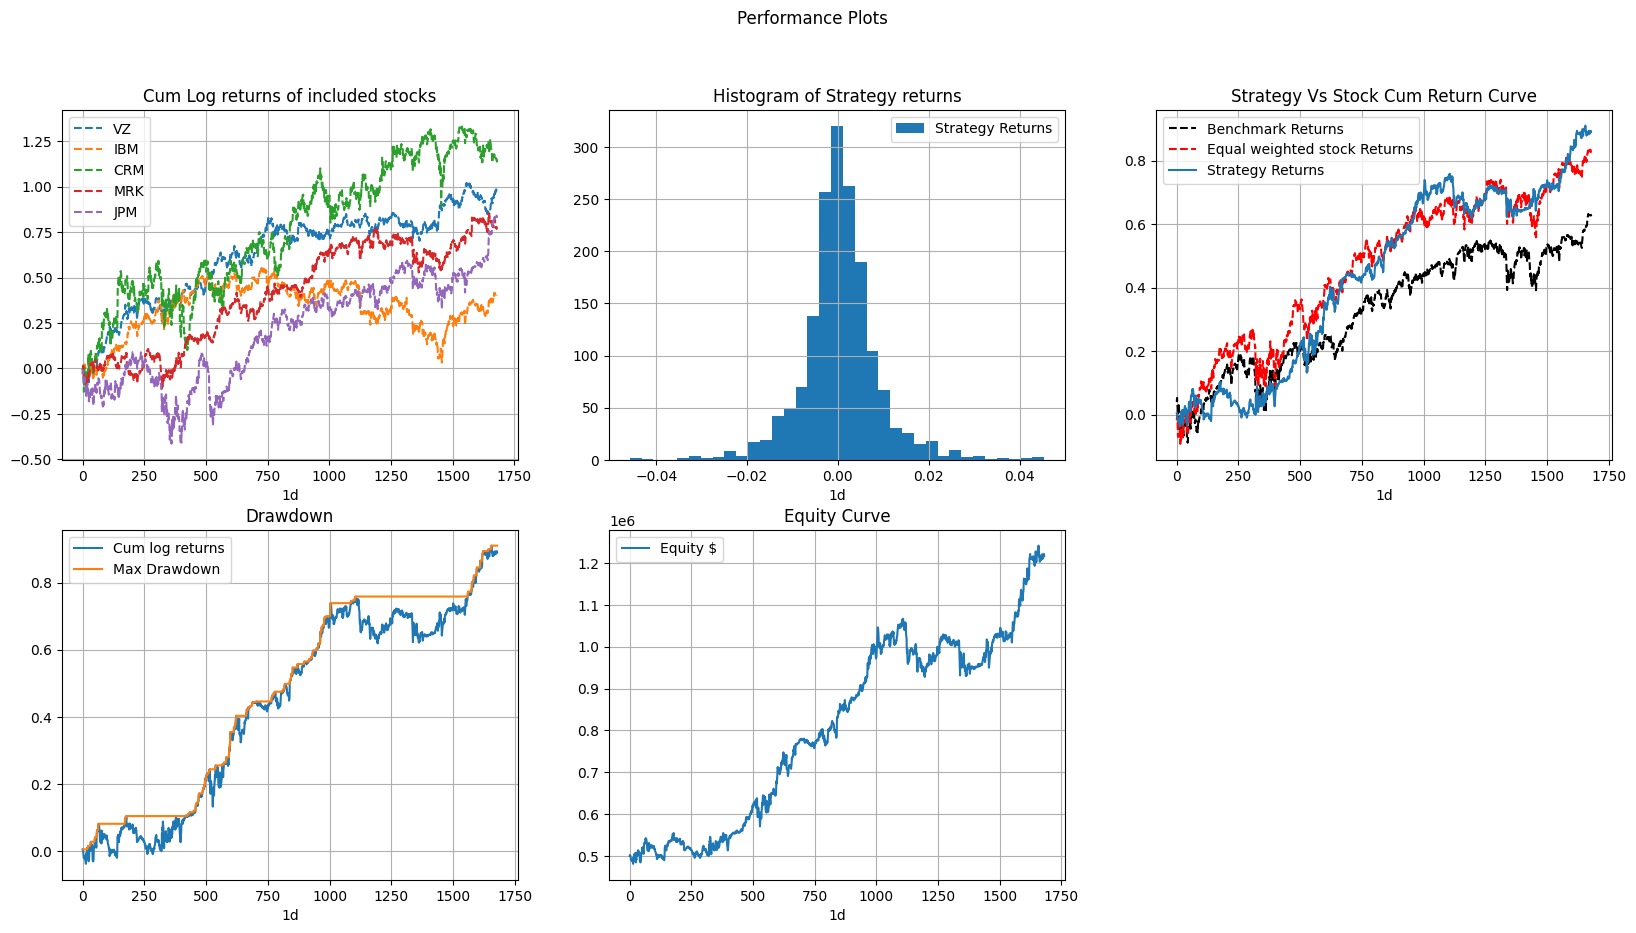

In [13]:
from sklearn.model_selection import ParameterGrid

stocks = ["VZ", "IBM", "CRM", "MRK", "JPM"]
benchmark = "^DJI"
param_grid = {
    # 'rsi_overbought': [70, 80],
    # 'rsi_oversold': [30, 20],
    # 'rsi_lower_threshold': [45],
    # 'rsi_upper_threshold': [55],
    # 'atr_window': [12, 14],
    # 'rsi_window': [12, 14],
    # 'bb_window': [16, 20],
    # 'bb_sd': [1.6, 2],
    # 'atr_multiplier': [3, 4],
    'ema_range': [0.040, 0.050],
    'ema_window': [80, 100],
    'entry_ratio': [0.50, 0.60, 0.70]
}

# to store the best set of results
iter, best_params, best_sharpe_ratio = 0, None, float('-inf')
A = G10_Strategy(stocks, benchmark, "2010-01-01", "2016-12-31", "1d", 500000, 0.005, verbose = False)

for params in ParameterGrid(param_grid):
    iter += 1
    A.run_strategy(**params) # pass the parameters into the strategy
    A.performance(p_verbose=False) # performance
    sharpe_ratio = A.performance_ratios['sharpe_ratio'] # Get the Sharpe ratio
    print(f"Iteration: {iter}, Sharpe Ratio: {sharpe_ratio}, Parameters: {params}")
    if sharpe_ratio > best_sharpe_ratio:
        best_params = params
        best_sharpe_ratio = sharpe_ratio

print(f"Search Complete! total iterations {iter}.")
print("="*100)
print(f"Best Parameters: {best_params}")
A.run_strategy(**best_params)
A.performance()
A.performance_plots()

# [Enhancement] Parameter Tuning: Parallelized
Does not work on Colab, run on local environment.

Despite being able to automate the parameter search process, we found that it was extremely slow as there are too many combinations and our resources were limited. One way to achieve better speed, is to make use of multiple cores on our computer. By parallellising our search, we can search more combinations effectively by reducing time.

In [4]:
import os

# Get the number of CPU cores
num_cores = os.cpu_count()

print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 8


Starting... Process ID: 17754
Starting... Process ID: 17751
Starting... Process ID: 17750
Starting... Process ID: 17753
Starting... Process ID: 17748
Starting... Process ID: 17752
Starting... Process ID: 17747
Starting... Process ID: 17749
Completed... Process ID: 17752, Sharpe Ratio: 0.4353704944771349, Parameters: {'atr_multiplier': 3, 'bb_sd': 1.6, 'bb_window': 16, 'ema_range': 0.04, 'ema_window': 80, 'entry_ratio': 0.7, 'rsi_window': 12}
Starting... Process ID: 17752
Completed... Process ID: 17754, Sharpe Ratio: -0.11925802426222554, Parameters: {'atr_multiplier': 3, 'bb_sd': 1.6, 'bb_window': 16, 'ema_range': 0.04, 'ema_window': 80, 'entry_ratio': 0.7, 'rsi_window': 14}
Starting... Process ID: 17754
Completed... Process ID: 17747, Sharpe Ratio: 0.4760176628586182, Parameters: {'atr_multiplier': 3, 'bb_sd': 1.6, 'bb_window': 16, 'ema_range': 0.04, 'ema_window': 80, 'entry_ratio': 0.6, 'rsi_window': 12}
Starting... Process ID: 17747
Completed... Process ID: 17749, Sharpe Ratio: 0.22

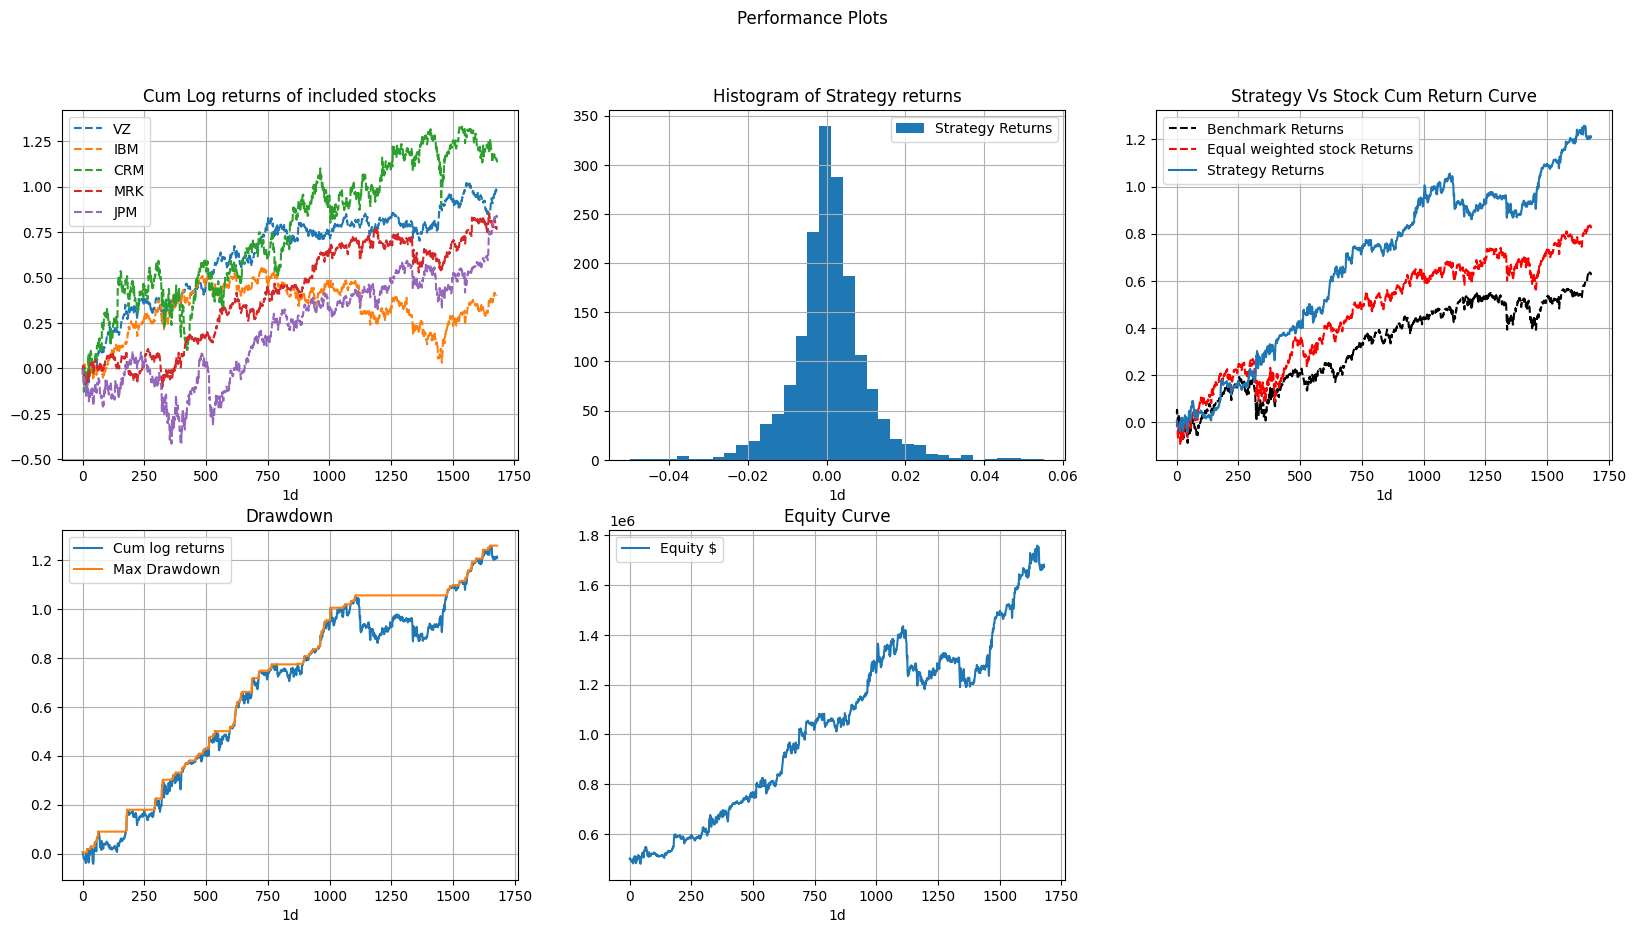

In [11]:
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed

def run_strategy_and_get_sharpe(params):
    process_id = os.getpid()
    print(f"Starting... Process ID: {process_id}")
    A = G10_Strategy(stocks, benchmark, "2010-01-01", "2016-12-31", "1d", 500000, 0.005, verbose=False)
    A.run_strategy(**params)
    A.performance(p_verbose=False)
    sharpe_ratio = A.performance_ratios['sharpe_ratio']
    print(f"Completed... Process ID: {process_id}, Sharpe Ratio: {sharpe_ratio}, Parameters: {params}")
    return sharpe_ratio, params

stocks = ["VZ", "IBM", "CRM", "MRK", "JPM"]
benchmark = "^DJI"
param_grid = {
    # 'rsi_overbought': [70, 80],
    # 'rsi_oversold': [30, 20],
    # 'rsi_lower_threshold': [45],
    # 'rsi_upper_threshold': [55],
    # 'atr_window': [12, 14],
    'rsi_window': [12, 14],
    'bb_window': [16, 20],
    'bb_sd': [1.6, 2],
    'atr_multiplier': [3, 4],
    'ema_range': [0.040, 0.050],
    'ema_window': [80, 100],
    'entry_ratio': [0.50, 0.60, 0.70]
}

# Set the number of parallel jobs
n_jobs = -1  # Use all available cores

# Use Parallel and delayed to parallelize the loop
results = Parallel(n_jobs=n_jobs)(delayed(run_strategy_and_get_sharpe)(params) for params in ParameterGrid(param_grid))

# Find the best results
best_sharpe_ratio, best_params = max(results)

print("=" * 100)
print(f"Search Complete!")
print(f"Best Sharpe Ratio: {best_sharpe_ratio}, Best Parameters: {best_params}")
A = G10_Strategy(stocks, benchmark, "2010-01-01", "2016-12-31", "1d", 500000, 0.005, verbose=False)
A.run_strategy(**best_params)
A.performance()
A.performance_plots()


# Out-sample Testing

Finally, we can test the performance of our strategy with the optimised parameters on unseen data. 

Performance Metrics
The total capital at end of strategy: 881821.08
The annual regular returns: 23.85 %
The annual regular std deviation: 20.95 %
The annual Sharpe Ratio: 1.14
The returns on investment from 2017-01-01 to 2019-12-31 by this strategy is 76.36 %
The maximum drawdown: 16.67 %
The maximum drawdown period: 95.00 days
The annual Calmar Ratio: 1.43
The annual Sortino Ratio: 1.99
The strategy's beta is -0.07 and alpha is 0.24 against ^DJI
The total trades taken by the strategy: 109
The total transaction cost spent by the strategy: 133243.34


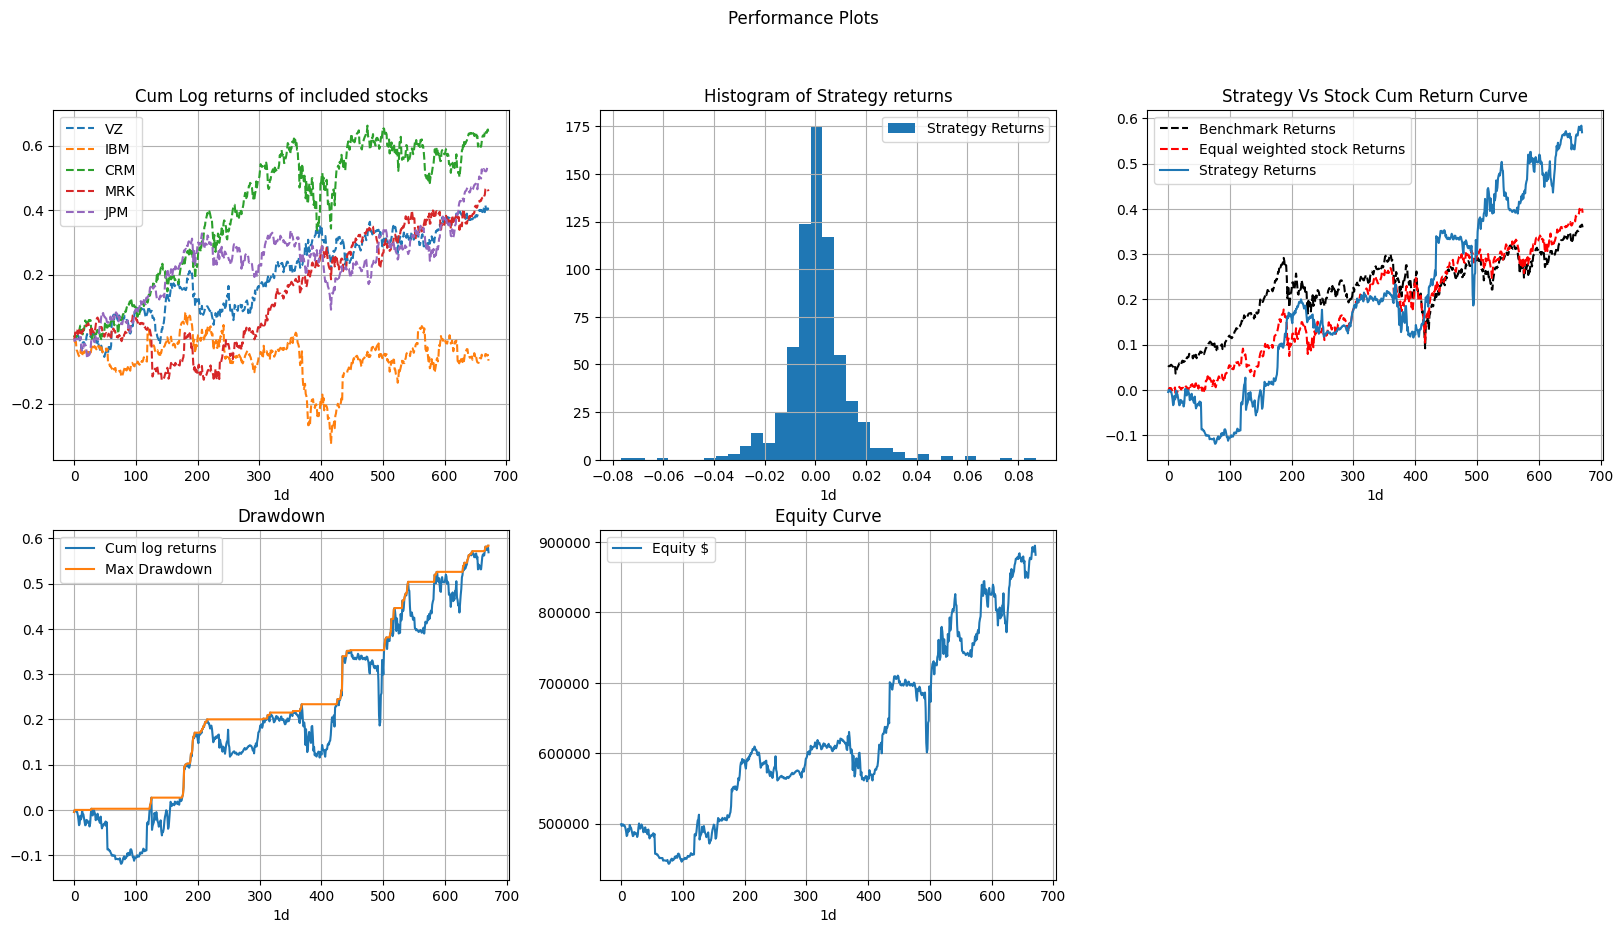

In [12]:
if __name__ == "__main__":
    stocks = ["VZ", "IBM", "CRM", "MRK", "JPM"]
    benchmark = "^DJI"
    A = G10_Strategy(stocks, benchmark, "2017-01-01", "2019-12-31", "1d", 500000, 0.005, verbose = False)
    # best parameters found
    A.run_strategy(**best_params)
    A.performance()
    A.performance_plots()